我们之前讨论的多层感知机十分适合处理表格数据，其中行对应样本，列对应特征。对于表格数据，我们寻找的模式可能涉及特征之间的交互，但是我们不能预先假设任何与特征交互相关的先验结构。此时，多层感知机可能是最好的选择，然而对于高维感知数据，这种缺少结构的网络可能会变得不实用。

本章介绍的卷积神经网络（convolutional neural network，CNN）是一类强大的、为处理图像数据而设计的神经网络。

在本章的开始，我们将介绍构成所有卷积网络主干的基本元素。这包括卷积层本身、填充（padding）和步幅（stride）的基本细节、用于在相邻区域汇聚信息的汇聚层（pooling）、在每一层中多通道（channel）的使用，以及有关现代卷积网络架构的仔细讨论。 

# 6.1. 从全连接层到卷积

## 6.1.1. 不变性

该检测器将图像分割成多个区域，并为每个区域包含沃尔多的可能性打分。卷积神经网络正是将空间不变性（spatial invariance）的这一概念系统化，从而基于这个模型使用较少的参数来学习有用的表示。

平移不变性（translation invariance）：不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。

局部性（locality）：神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

## 6.1.2. 多层感知机的限制

首先，多层感知机的输入是二维图像$X$，其隐藏表示$H$在数学上是一个矩阵，在代码中表示为二维张量。其中$X$和$H$具有相同的形状。为了方便理解，我们可以认为，无论是输入还是隐藏表示都拥有空间结构。

### 6.1.2.1. 平移不变性

 $$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$
 
 这意味着检测对象在输入$X$中的平移，应该仅导致隐藏表示$H$中的平移。

### 6.1.2.2. 局部性

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

简而言之，是一个卷积层（convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。在深度学习研究社区中，$V$被称为卷积核（convolution kernel）或者滤波器（filter），亦或简单地称之为该卷积层的权重，通常该权重是可学习的参数。

## 6.1.3. 卷积

## 6.1.4. “沃尔多在哪里”回顾

卷积层根据滤波器$V$选取给定大小的窗口，并加权处理图片。

### 6.1.4.1. 通道

我们忽略了图像一般包含三个通道/三种原色（红色、绿色和蓝色）。实际上，图像不是二维张量，而是一个由高度、宽度和颜色组成的三维张量，比如包含1024×1024×3个像素。

由于输入图像是三维的，我们的隐藏表示$H$也最好采用三维张量。 

对于每一个空间位置，我们想要采用一组而不是一个隐藏表示。这样一组隐藏表示可以想象成一些互相堆叠的二维网格。因此，我们可以把隐藏表示想象为一系列具有二维张量的通道（channel）。这些通道有时也被称为特征映射（feature maps），因为每个通道都向后续层提供一组空间化的学习特征。

# 6.2. 图像卷积

## 6.2.1. 互相关运算

卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），而不是卷积运算。

首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。

输入是高度为3、宽度为3的二维张量（即形状为3×3）。卷积核的高度和宽度都是2，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即2×2）。




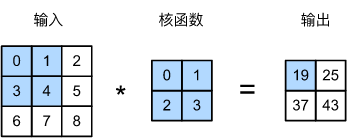

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。 

输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1，而卷积核只与图像中每个大小完全适合的位置进行互相关运算。所以，输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。

接下来，我们在corr2d函数中实现如上过程，该函数接受输入张量X和卷积核张量K，并返回输出张量Y。

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l
import torch
from torch import nn
from d2l import torch as d2l

!pip uninstall matplotlib -y
!pip install matplotlib==3.0.0

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-ta100sno
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-ta100sno
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 135 kB/s 
     |████████████████████████████████| 11.2 MB 55.2 MB/s 
     |████████████████████████████████| 61 kB 9.3 MB/s 
     |████████████████████████████████| 9.9 MB 60.6 MB/s 
     |████████████████████████████████| 930 kB 56.0 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=6a526801b810a96e2233db25cd2e8bd46996e46067576e030e435b08b5d4b3bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-m6bulmvu/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully b

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 12.8 MB 25.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 2.0.0b0 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
def corr2d(X, K): 
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 6.2.2. 卷积层

基于上面定义的corr2d函数实现二维卷积层。在__init__构造函数中，将weight和bias声明为两个模型参数。前向传播函数调用corr2d函数并添加偏置。

In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

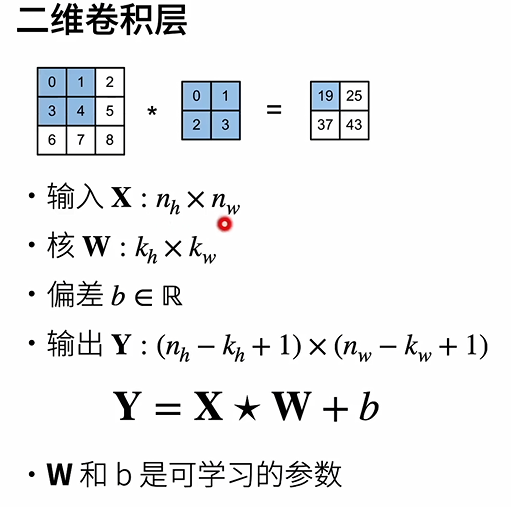

## 6.2.3. 图像中目标的边缘检测

首先，我们构造一个6×8像素的黑白图像。中间四列为黑色（0），其余像素为白色（1）。

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 6.2.4. 学习卷积核

In [ ]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 10.350
epoch 4, loss 3.179
epoch 6, loss 1.124
epoch 8, loss 0.431
epoch 10, loss 0.171


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0314, -0.9468]])

## 6.2.5. 互相关和卷积

## 6.2.6. 特征映射和感受野

# 6.3. 填充和步幅

因此，卷积的输出形状取决于输入形状和卷积核的形状。

还有什么因素会影响输出的大小呢？本节我们将介绍填充（padding）和步幅（stride）。

如此一来，原始图像的边界丢失了许多有用信息。而填充是解决此问题最有效的方法。有时，我们可能希望大幅降低图像的宽度和高度。例如，如果我们发现原始的输入分辨率十分冗余。步幅则可以在这类情况下提供帮助。

## 6.3.1. 填充

由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。但随着我们应用许多连续卷积层，累积丢失的像素数就多了。解决这个问题的简单方法即为填充（padding）：在输入图像的边界填充元素（通常填充元素是0）。

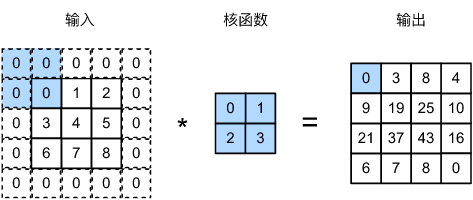

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。

在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。这样可以在构建网络时更容易地预测每个图层的输出形状。假设$k_h$是奇数，我们将在高度的两侧填充$p_h/2$行。如果$k_h$是偶数，则一种可能性是在输入顶部填充$\lceil p_h/2\rceil$行，在底部填充$\lfloor p_h/2\rfloor$行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

此外，使用奇数的核大小和填充大小也提供了书写上的便利。对于任何二维张量`X`，当满足：
1. 卷积核的大小是奇数
2. 所有边的填充行数和列数相同
3. 输出与输入具有相同高度和宽度

则可以得出：输出`Y[i, j]`是通过以输入`X[i, j]`为中心，与卷积核进行互相关计算得到的。

In [ ]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 6.3.2. 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。在前面的例子中，我们默认每次滑动一个元素。但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为步幅（stride）。

可以看到，为了计算输出中第一列的第二个元素和第一行的第二个元素，卷积窗口分别向下滑动三行和向右滑动两列。但是，当卷积窗口继续向右滑动两列时，没有输出，因为输入元素无法填充窗口（除非我们添加另一列填充）。

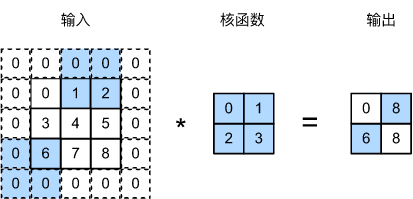

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。
更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h) \times (n_w/s_w)$。

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

为了简洁起见，当输入高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h, p_w)$。当$p_h = p_w = p$时，填充是$p$。同理，当高度和宽度上的步幅分别为$s_h$和$s_w$时，我们称之为步幅$(s_h, s_w)$。当时的步幅为$s_h = s_w = s$时，步幅为$s$。默认情况下，填充为0，步幅为1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有$p_h = p_w$和$s_h = s_w$。

# 6.4. 多输入多输出通道

彩色图像具有标准的RGB通道来代表红、绿和蓝。但是到目前为止，我们仅展示了单个输入和单个输出通道的简化例子。这使得我们可以将输入、卷积核和输出看作二维张量。

当我们添加通道时，我们的输入和隐藏的表示都变成了三维张量。例如，每个RGB输入图像具有$3\times h\times w$的形状。我们将这个大小为$3$的轴称为*通道*（channel）维度。

## 6.4.1. 多输入通道

当输入包含多个通道时，需要构造一个与输入数据具有相同输入通道数的卷积核，以便与输入数据进行互相关运算。假设输入的通道数为$c_i$，那么卷积核的输入通道数也需要为$c_i$。如果卷积核的窗口形状是$k_h\times k_w$，那么当$c_i=1$时，我们可以把卷积核看作形状为$k_h\times k_w$的二维张量。

然而，当$c_i>1$时，我们卷积核的每个输入通道将包含形状为$k_h\times k_w$的张量。将这些张量$c_i$连结在一起可以得到形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将$c_i$的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

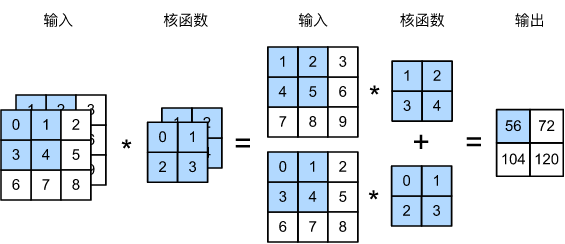

为了加深理解，我们实现一下多输入通道互相关运算。简而言之，我们所做的就是对每个通道执行互相关操作，然后将结果相加。

In [ ]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

## 6.4.2. 多输出通道

到目前为止，不论有多少输入通道，我们还只有一个输出通道。然而，每一层有多个输出通道是至关重要的。

用$c_i$和$c_o$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i\times k_h\times k_w$的卷积核张量，这样卷积核的形状是$c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

In [ ]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 3, 2, 2, 2])

## 6.4.3. $1×1$卷积层

因为使用了最小窗口，$1\times 1$卷积失去了卷积层的特有能力——在高度和宽度维度上，识别相邻元素间相互作用的能力。其实$1\times 1$卷积的唯一计算发生在通道上。

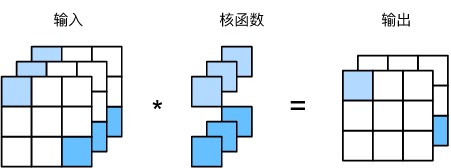

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 6.5. 汇聚层

通常当我们处理图像时，我们希望逐渐降低隐藏表示的空间分辨率、聚集信息，这样随着我们在神经网络中层叠的上升，每个神经元对其敏感的感受野（输入）就越大。

而我们的机器学习任务通常会跟全局图像的问题有关（例如，“图像是否包含一只猫呢？”），所以我们最后一层的神经元应该对整个输入的全局敏感。通过逐渐聚合信息，生成越来越粗糙的映射，最终实现学习全局表示的目标，同时将卷积图层的所有优势保留在中间层。

此外，当检测较底层的特征时（例如边缘），我们通常希望这些特征保持某种程度上的平移不变性。

本节将介绍汇聚（pooling）层，它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

## 6.5.1. 最大汇聚层和平均汇聚层

与卷积层类似，汇聚层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为汇聚窗口）遍历的每个位置计算一个输出。然而，不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。相反，池运算是确定性的，我们通常计算汇聚窗口中所有元素的最大值或平均值。这些操作分别称为最大汇聚层（maximum pooling）和平均汇聚层（average pooling）。

在这两种情况下，与互相关运算符一样，汇聚窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在汇聚窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大汇聚层还是平均汇聚层。

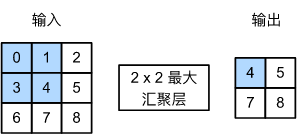

输出张量的高度为$2$，宽度为$2$。这四个元素为每个汇聚窗口中的最大值：

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

汇聚窗口形状为$p \times q$的汇聚层称为$p \times q$汇聚层，汇聚操作称为$p \times q$汇聚。

在下面的代码中的`pool2d`函数，我们(**实现汇聚层的前向传播**)。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

此外，我们还可以验证平均汇聚层。

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## 6.5.2. 填充和步幅

与卷积层一样，汇聚层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。下面，我们用深度学习框架中内置的二维最大汇聚层，来演示汇聚层中填充和步幅的使用。

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

当然，我们可以设定一个任意大小的矩形汇聚窗口，并分别设定填充和步幅的高度和宽度。

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 6.5.3. 多个通道

在处理多通道输入数据时，汇聚层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。这意味着汇聚层的输出通道数与输入通道数相同。下面，我们将在通道维度上连结张量X和X + 1，以构建具有2个通道的输入。

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 6.6. 卷积神经网络（LeNet）

回想一下，之前我们将softmax回归模型和多层感知机模型应用于Fashion-MNIST数据集中的服装图片。为了能够应用softmax回归和多层感知机，我们首先将每个大小为$28\times28$的图像展平为一个784维的固定长度的一维向量，然后用全连接层对其进行处理。而现在，我们已经掌握了卷积层的处理方法，我们可以在图像中保留空间结构。同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

在本节中，我们将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。

LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

## 6.6.1. LeNet

总体来看，LeNet（LeNet-5）由两个部分组成：

卷积编码器：由两个卷积层组成;

全连接层密集块：由三个全连接层组成。

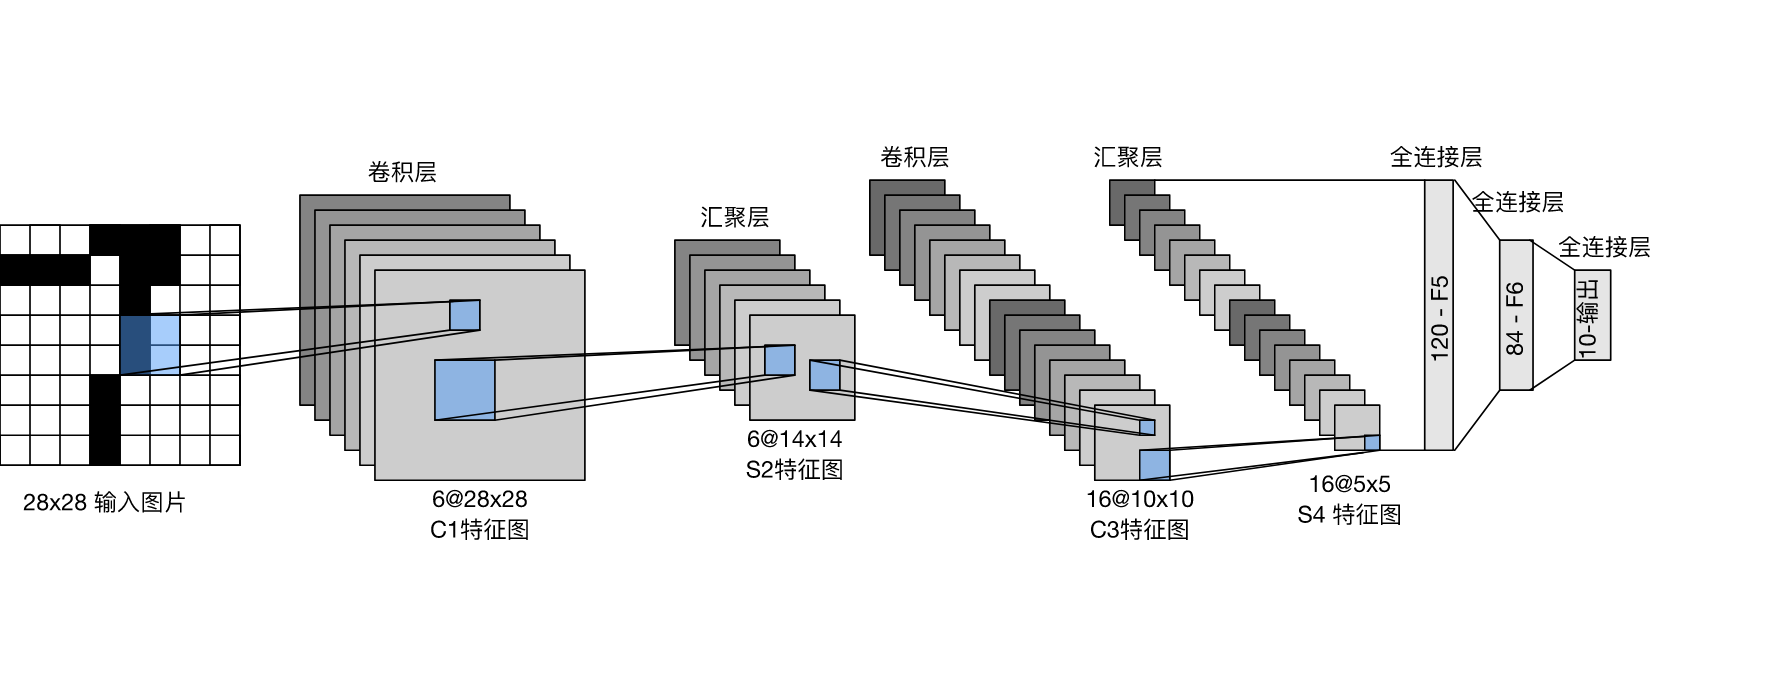

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2\times2$池操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

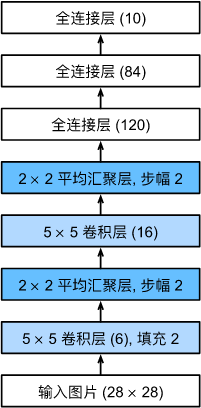

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


请注意，在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。

## 6.6.2. 模型训练

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

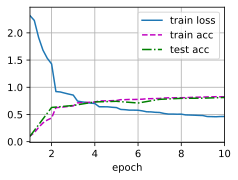

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())